In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
#from collections import Counter
#import nltk

In [2]:
bibleraw = pd.read_json('https://raw.githubusercontent.com/bibleapi/bibleapi-bibles-json/master/asv.json', lines = True)

In [3]:
bibleraw.head()

,book_id,book_name,chapter,text,translation_id,verse
0,Gen,Genesis,1,In the beginning God created the heavens and t...,ASV,1
1,Gen,Genesis,1,And the earth was waste and void; and darkness...,ASV,2
2,Gen,Genesis,1,"And God said, Let there be light: and there wa...",ASV,3
3,Gen,Genesis,1,"And God saw the light, that it was good: and G...",ASV,4
4,Gen,Genesis,1,"And God called the light Day, and the darkness...",ASV,5


In [4]:
#accidentally download the quran in original arabic, unfortunately it can't be useful.
quranraw = open('../__DATA__/Holy Texts/quran-simple.txt','r')
quranraw = quranraw.read()
quranraw[:1000]

'بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ\nالْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ\nالرَّحْمَنِ الرَّحِيمِ\nمَالِكِ يَوْمِ الدِّينِ\nإِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ\nاهْدِنَا الصِّرَاطَ الْمُسْتَقِيمَ\nصِرَاطَ الَّذِينَ أَنْعَمْتَ عَلَيْهِمْ غَيْرِ الْمَغْضُوبِ عَلَيْهِمْ وَلَا الضَّالِّينَ\nبِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ الم\nذَلِكَ الْكِتَابُ لَا رَيْبَ فِيهِ هُدًى لِلْمُتَّقِينَ\nالَّذِينَ يُؤْمِنُونَ بِالْغَيْبِ وَيُقِيمُونَ الصَّلَاةَ وَمِمَّا رَزَقْنَاهُمْ يُنْفِقُونَ\nوَالَّذِينَ يُؤْمِنُونَ بِمَا أُنْزِلَ إِلَيْكَ وَمَا أُنْزِلَ مِنْ قَبْلِكَ وَبِالْآخِرَةِ هُمْ يُوقِنُونَ\nأُولَئِكَ عَلَى هُدًى مِنْ رَبِّهِمْ وَأُولَئِكَ هُمُ الْمُفْلِحُونَ\nإِنَّ الَّذِينَ كَفَرُوا سَوَاءٌ عَلَيْهِمْ أَأَنْذَرْتَهُمْ أَمْ لَمْ تُنْذِرْهُمْ لَا يُؤْمِنُونَ\nخَتَمَ اللَّهُ عَلَى قُلُوبِهِمْ وَعَلَى سَمْعِهِمْ وَعَلَى أَبْصَارِهِمْ غِشَاوَةٌ وَلَهُمْ عَذَابٌ عَظِيمٌ\nوَمِنَ النَّاسِ مَنْ يَقُولُ آمَنَّا بِاللَّهِ وَبِالْيَوْمِ الْآخِرِ وَمَا هُمْ بِمُؤْمِنِينَ\nيُخَادِعُونَ اللَّهَ وَ

In [5]:
import glob
import os

file_list = glob.glob(os.path.join(os.getcwd(), "../__DATA__/Holy Texts/quran-verse-by-verse-text", "*.txt"))
file_list.sort()

quran_verses = []

for file_path in file_list:
    with open(file_path) as f_input:
        quran_verses.append(f_input.read())

Ways of organizing the analysis:
- We will be performing a model that classifies OT vs. NT. 

In [6]:
len(quran_verses)

6349

In [7]:
quran_verses[6348]

"The Quran\nModern English Translation\nVerse by Verse\n\nTranslated by Talal Itani\nwww.ClearQuran.com\n\nAvailable in two editions. This edition (A) uses the word 'Allah' to refer to the Creator. Edition (B) uses the word 'God'.\n\nThese files can be shared and distributed\nProvided under the Creative Commons License\nAttribution-NonCommercial-NoDerivs\n\n"

In [8]:
#but it doesn't matter anyways because I just decided that I don't to use the Quran.

In [9]:
bibleraw['book_name'].unique()

array(['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi',
       'Matthew', 'Mark', 'Luke', 'John', 'Acts of the Apostles',
       'Romans', '1 Corinthians', '2 Corinthians', 'Galatians',
       'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians',
       '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
       'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
       '3 John', 'Jude', 'Revelation'], dtype=object)

In [10]:
#Creating list of Old Testament and New Testament Chapters
OT = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi']
NT = ['Matthew', 'Mark', 'Luke', 'John', 'Acts of the Apostles',
       'Romans', '1 Corinthians', '2 Corinthians', 'Galatians',
       'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians',
       '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
       'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
       '3 John', 'Jude', 'Revelation']

In [11]:
bible = bibleraw.copy()
bible['testament'] = ''
bible['book_chapter'] = ''
bible.loc[bible['book_name'].isin(OT), 'testament'] = 'OT'
bible.loc[bible['book_name'].isin(NT), 'testament'] = 'NT'

In [12]:
#Creating a new dataframe with bible with each row as a chapter. These rows will be our documents.
bible_chapters = pd.DataFrame(columns = bible.columns)
i = 0
books = bible.book_name.unique()
for book in books:
    chapters = bible[bible['book_name'] == book].chapter.unique()
    for chapter in chapters:
        book_chapter = book + ' ' + str(chapter)
        text = bible[(bible['book_name'] == book) & (bible['chapter'] == chapter)].text
        if book in OT:
            testament = 'OT'
        elif book in NT:
            testament = 'NT'
        bible_chapters.loc[i, ['book_name','chapter','book_chapter','text','testament']] = [book, chapter, book_chapter, ' '.join(text), testament]
        i += 1

In [13]:
bible_chapters = bible_chapters[['book_name','chapter','book_chapter','text','testament']]
bible_chapters.head()

,book_name,chapter,book_chapter,text,testament
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT


In [22]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

# Utility Functions for word tokenizing document for BOW analysis
def bag_of_bags(document_list):
    
    '''Creating bags of differents spacy token types. Outputs 5 different
    bags. Utilize the function as follows:
    
    allwords, allents, allnps, alltags, alltokens = bag_of_bags(document_list)
    '''
    
    #Intializing Text Parser
    from collections import Counter
    nlp = spacy.load('en')

    #Parsing the Text
    text = ' '.join(document_list)
    text = nlp(text)
        
    # Words
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    allwords = [item[0] for item in Counter(allwords).most_common(1000)]
    
    # Entities
    allents = [str(ent)+' ENT' for ent in text.ents]
    allents = [item[0] for item in Counter(allents).most_common(250)]

    # Noun Phrases
    allnps = [str(np)+' NPHR' for np in text.noun_chunks]
    allnps = [item[0] for item in Counter(allnps).most_common(500)]
    
    # Words with POS Tags
    alltags = [token.lemma_+' '+token.tag_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    alltags = [item[0] for item in Counter(alltags).most_common(1000)]
    
    # combining all token categories into one list
    alltokens = allwords + allents + allnps + alltags
    
    return allwords, allents, allnps, alltags, alltokens
    
def bob_features(document_list):
    
    # Initialize NLP SpaCy Processor
    nlp = spacy.load('en')
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=alltokens)
    df['document_text'] = document_list
    df.loc[:, alltokens] = 0
    
    # Process each row, counting the occurrence of tokens in each sentence.
    for i, document in enumerate(df['document_text']):
        
        document = nlp(document)
        
        words = [token.lemma_
                 for token in document
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in allwords
                 )]
        
        ents = [str(ent)+' ENT'
                 for ent in document.ents
                 if str(ent) + ' ' in allents
                 ]
        
        nps = [str(np)+' NPHR'
                 for np in document.noun_chunks
                 if str(np)+' NPHR' in allnps
                 ]
        
        tags = [token.lemma_+' '+token.tag_
                 for token in document
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and (token.lemma_+' '+token.tag_) in alltags
                 )]
        
        tokens = words + ents + nps + tags
        
        # Populate the row with word counts.
        for token in tokens:
            df.loc[i, token] += 1
            
        # This counter is just to make sure the kernel didn't hang.
        if i % 10 == 0:
            print("Processing row {}".format(i))

    return df

# Utility function for word tokenizing documents for tf-idf preparation
def document_tokenizer(raw_documents_list):
     
    '''Takes a list of documents and returns corresponding list (same shape) of lemmatized tokens,
     entities, noun_phrases, and POS_tagged words all returned as strings. Each token has spaces replaced
     with underscores _ so that tfidfvectorizor can process each token as a single word.
     
     raw_documents_list should be cleaned of any text that spacy can't process.'''

    #Initialize Output List of Document Tokens, and SpaCy NLP Preprocessor
    tokenized_documents = []
    
    #individually spacy process the documents in the original documents list
    documents = [ nlp(document) for document in raw_documents_list ]
    
    #tokenizing text by token category
    for text in documents:
    
        allwords = [token.lemma_
                    for token in text
                    if not token.is_punct
                    and not token.is_stop]

        allents = []
        for ent in text.ents:
            string_ent = str(ent).strip('[]').strip().replace(' ','_') #Spaces in token replaced with underscore #also remove extraneous brackets as last second tweak
            allents.append(string_ent + '_ENTITY') #label as entity, differentiate from words

        allnps = []
        for np in text.noun_chunks:
            string_np = str(np).strip('[]').strip().replace(' ','_') #Spaces in token replaced with underscore #also remove extraneous brackets as last second tweak
            allnps.append(string_np + '_NPHRASE') #label as NPHRASE, differentiate from words

        alltags = [token.lemma_ + '_' + token.tag_ #Spaces in token replaced with underscore
                    for token in text
                    if not token.is_punct
                    and not token.is_stop]
        
        #aggregating all document token categories into one string per document and appending list of strings
        #to the final tokenized document list
        doc_tok_cats = [allwords, allents, allnps, alltags] 
        doc_tokens = [' '.join(cat) for cat in doc_tok_cats]
        tokenized_documents.append(' '.join(doc_tokens)) 
        
    return tokenized_documents

In [15]:
chapters_clean = []
for chapter in bible_chapters.text:
    chapters_clean.append(text_cleaner(chapter))

In [16]:
#checking the length.
len(' '.join(chapters_clean))

4117953

## Bag of Words (Bag of bags) Features and Modeling to predict which testament a chapter is from.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Splitting the data into training and test sets. The sizes of each set can not exceed
# 1 million characters in text due to computing limitations, although this number can be changed.
bible_df = bible_chapters.copy()
bible_df['text'] = chapters_clean
train_set, test_set = train_test_split(bible_df, train_size = 0.2, random_state = 5)
test_set = resample(test_set, n_samples = train_set.shape[0], random_state = 10)

In [20]:
# Stitching the bags together; creating these bags is similar to fitting the model,
# since it requires feature extraction of a training set.
allwords, allents, allnps, alltags, alltokens = bag_of_bags(train_set.text)


In [23]:
train_counts = bob_features(list(train_set.text))

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230


In [24]:
test_counts = bob_features(list(test_set.text))

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230


In [25]:
#adding 
train_counts['testament'] = train_set['testament']

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_train = train_counts.loc[:, ~(train_counts.columns).isin(['document_text','testament'])]
Y_train = train_set['testament']

clf = LogisticRegression()
clf.fit(X_train,Y_train)
predict = clf.predict(test_counts.loc[:, ~(test_counts.columns).isin(['document_text'])])
conmat = confusion_matrix(test_set['testament'], predict)
display(conmat)
clf.score(test_counts.loc[:, ~(test_counts.columns).isin(['document_text'])], test_set['testament'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 42,   1],
       [  2, 192]])

0.9873417721518988

The model turned out great. Prediction accuracy when rounded is 99%

# Predictive Model using TF-IDF Features

In [27]:
# Creating column to tokenize each chapter 
nlp = spacy.load('en')
bible_df['token_text'] = document_tokenizer(bible_df.text)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating training and test sets for TF-IDF
train_set, test_set = train_test_split(bible_df, train_size = 0.2, random_state = 6)
#test_set = resample(test_set, n_samples = len(text_train), random_state = 11)

X_train = train_set['token_text']
Y_train = train_set['testament']
X_test = test_set['token_text']
Y_test = test_set['testament']

#TF-IDF Transforming the text using X_train training set
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])


Number of features: 10822


In [29]:
# Creating a predictive model
clf = LogisticRegression()
clf.fit(X_train_tfidf, Y_train)
predict = clf.predict(X_test_tfidf)
conmat = confusion_matrix(Y_test, predict)
display(conmat)
clf.score(X_test_tfidf, Y_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[136,  60],
       [  0, 756]])

0.9369747899159664

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
clf = LogisticRegression()

tfidf_clf_model = Pipeline(steps=[('tfidf', vectorizer),('lreg classifier', clf)])
cross_val_score(tfidf_clf_model, bible_df['token_text'], bible_df['testament'], cv = 5)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.94957983, 0.98319328, 0.94957983, 0.97478992, 0.88185654])

The cross validation scores all look great besides the last fold, which creates a 10% spread between itself and the highest score

# Unsupervised Clustering and Feature Extraction to predict Authors 


Action Plan:
0. Add Authors corresponding the chapters within the dataset, and prune data of NA rows and outliers
0.5. Split data into test and training sets
0.75. Set up architecture for creating multiple folds os test/train data
1. Perform Unsupervised Clustering on the text chapters, using BOW or TF-IDF features. Then experiment with all of the clustering techniques to see the kinds of clusters your model comes up with.
2. Then do some feature generation (PCA, LSA(SVD)) and selection (explained_variance_ratio_ of components).
3. then use these components to classify texts based on author.

### --- Cleaning and Prep

In [31]:
bible_df.head()

,book_name,chapter,book_chapter,text,testament,token_text
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...


### --- Adding Authors, then Removing Outliers and Unknown Authors

Note About the Authors:

Many of the authors of the Bible and for certain chapters of the books of the Bible are disputed. I compiled the list of authors very roughly based especially on Jewish Tradition for the Old Testament. The New Testament authors are much less disputed.

Chapters with completely unknown authors were removed from the data set and authors who also contributed to less than 10 chapters to the Bible were also removed.

The following sources were used in compiling the authors. 

[Link](https://overviewbible.com/authors-who-wrote-bible/) [Link](https://www.whatchristianswanttoknow.com/books-of-the-bible-complete-list-with-authors/) [Link](https://www.gotquestions.org/Psalms-authors.html) [Link](https://overviewbible.com/authors-who-wrote-bible/) [Link](https://www.bibleinfo.com/en/questions/who-wrote-the-bible) [Link](https://www.quora.com/Who-was-the-writer-of-the-Book-of-Kings-in-the-Bible) [Link](https://en.wikipedia.org/wiki/Books_of_Samuel) [Link](https://www.quora.com/Who-wrote-Deuteronomy-34) [Link](https://www.haaretz.com/jewish/.premium-who-wrote-the-book-of-esther-1.5331950)

In [32]:
# Copying the data frame to clipboard to work in excel; easier to manually enter authors from there
bible_df[['book_name', 'chapter', 'book_chapter']].to_clipboard()

In [33]:
# The dataframe above was copied to a google sheet and the authors were added manually to another column using the data from a couple websites
bible_authors = pd.read_csv('../__DATA__/Holy Texts/Bible Chapter Authors.csv')
bible_df['author'] = bible_authors['author']
bible_df.head()

,book_name,chapter,book_chapter,text,testament,token_text,author
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...,Moses
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...,Moses
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...,Moses
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...,Moses
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...,Moses


In [34]:
bible_known = bible_df.copy().dropna(axis=0)
print(bible_known.shape)
bible_known.head()

(1125, 7)


,book_name,chapter,book_chapter,text,testament,token_text,author
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...,Moses
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...,Moses
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...,Moses
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...,Moses
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...,Moses


In [35]:
authors_to_drop = []
for author in bible_known.author.unique():
    if (bible_known.groupby('author').count()['text'] < 10)[author] == True:
        authors_to_drop.append(author)
authors_to_drop

['Ethan the Ezrahite',
 'Agur',
 'Lemuel',
 'Joel',
 'Amos',
 'Obadiah',
 'Jonah',
 'Micah',
 'Nahum',
 'Habakkuk',
 'Zephaniah',
 'Haggai',
 'Malachi',
 'James',
 'Peter',
 'Jude']

In [36]:
index_drop = bible_known.loc[bible_known['author'].isin(authors_to_drop)].index
bible_pruned = bible_known.drop(index = index_drop)
bible_pruned = bible_pruned.reset_index().drop(columns = ['index'])
bible_pruned.head()

,book_name,chapter,book_chapter,text,testament,token_text,author
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...,Moses
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...,Moses
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...,Moses
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...,Moses
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...,Moses


### --- Clustering Game Plan
1. Bag of Words
2. TF-IDF

Then for these feature sets:
1. KMeans
2. Mean Shift
3. Spectral Affinity

Clustering Game Plan:

Create BOW or TF-IDF features to then perform multiple clustering methods.
Compare the kinds of clusters that BOW and TF-IDF Clustering Creates.

## 1. BOW Clustering


In [37]:
train_set, test_set = train_test_split(bible_pruned, train_size = 0.80, random_state = 7)
train_set = resample(train_set, n_samples = len(test_set), random_state = 12)

In [38]:
# Compiling Bag Categories and Token
allwords, allents, allnps, alltags, alltokens = bag_of_bags(train_set.text)
#bob_features(train)

In [39]:
# Transforming the train_set into a BoB using its tokens.
train_set_bob = bob_features(train_set.reset_index().text)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210


In [40]:
# Transform test_set into bob dataframe using the features created using the data set
test_set_bob = bob_features(test_set.reset_index().text)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210


In [41]:
# reindexing bob count dataframes to match random indexing of train_set and test_set ordering
# dropping the text columns so to run PCA
train_set_bob = train_set_bob.set_index(train_set.index).drop(columns=['document_text'])
test_set_bob = test_set_bob.set_index(test_set.index).drop(columns=['document_text'])

In [42]:
# Decreasing the Dimensionality of the Training Set through PCA
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Don't forget to normalize before PCA! Allows for eahc feature to be weighted equally
train_bob_norm = normalize(train_set_bob)
test_bob_norm = normalize(test_set_bob)

# Reducing the dimensions
pca = PCA(100)
pca.fit(train_bob_norm)
train_bob_pca = pca.transform(train_bob_norm)
test_bob_pca = pca.transform(test_bob_norm)

print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[0.07319859 0.05631813 0.05150144 0.04619278 0.0369635  0.0313125
 0.02926788 0.02450094 0.02348689 0.02128358 0.02047276 0.01872363
 0.01646139 0.01578985 0.0146403  0.01358779 0.01316743 0.01296898
 0.01173645 0.01111741 0.01098765 0.01042119 0.01000269 0.00951611
 0.00914677 0.00888016 0.00852682 0.00819055 0.00784261 0.00774792
 0.0075446  0.00716342 0.00691372 0.00681181 0.00668024 0.00625961
 0.00611719 0.00606388 0.0059408  0.00573582 0.00565257 0.00551816
 0.00541173 0.00529542 0.00514914 0.00510425 0.00497442 0.00492013
 0.00475912 0.00471109 0.00450877 0.00447251 0.00441048 0.0043391
 0.00425228 0.00420871 0.0041431  0.00407317 0.00401653 0.00397048
 0.00386653 0.00379892 0.00367135 0.00360379 0.00357801 0.00349776
 0.00342535 0.00332291 0.00330263 0.00325773 0.00313048 0.00311353
 0.00307258 0.00293812 0.00288647 0.00283858 0.00280871 0.0027831
 0.00272811 0.00269288 0.00265972 0.00260367 0.00257804 0.00249283
 0.00247101 0.00245679 0.00240221 0.00237619 0.00235032 0.0023013

0.9031447184551511

Text(0, 0.5, 'Explained Variance Ratio')

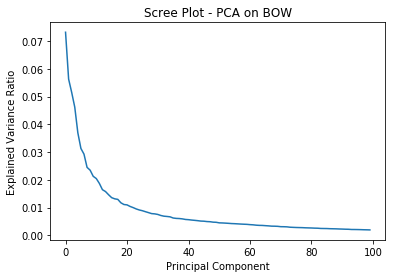

In [43]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot - PCA on BOW')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

### --- 1a. KMeans

Text(0, 0.5, 'Sum of squared distance')

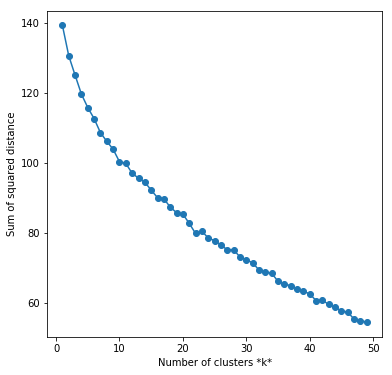

In [44]:
# Using elbow method to to optimize the number of clusters vs. clustering based on the number of authors in the pruned dataset
from sklearn.cluster import KMeans

sse = []
list_k = list(range(1, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state = 50)
    km.fit(train_bob_pca)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Passed 10 clusters, the rate of change for slope of the SSE decreases significanly, as the number of clusters increases without showing strongly sharp elbow. Arguably, the "elbow" of this SSE curve occurs anywhere between 10 and 30 clusters, and since the number of authors in the pruned dataset lies between these two cluster numbers, we'll cluster based on the number of authors.

Text(0, 0.5, 'Silhouette Score')

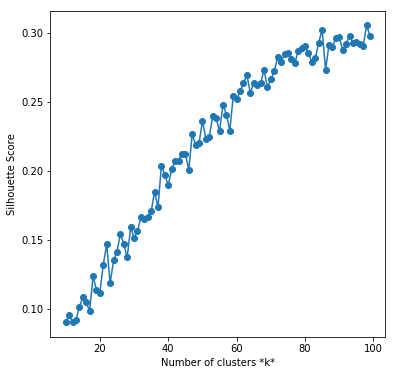

In [45]:
# Silhouette Analysis
from sklearn.metrics import silhouette_score

silhouette_vals = []
list_k = list(range(10, 100))

for k in list_k:
    km = KMeans(n_clusters=k, random_state = 50)
    cluster_labels = km.fit_predict(train_bob_pca)
    sil_score = silhouette_score(train_bob_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

The silhouette score increases pseudo-monotonically as the number of clusters increases. There  doesn't seem to be any definitive clustering pattern that KMeans is able to create besides splitting Bible book chapters into smaller and smaller groups. Below, we will go ahead and cluster based on the number of authors in the data set to what the clusters groups the chapters together.

In [46]:
# implementing K-means Clustering
from sklearn.cluster import KMeans

n_clusters = bible_pruned['author'].nunique()

kmeans = KMeans(n_clusters = n_clusters, random_state = 30)
kmeans.fit(train_bob_pca)
km_train_clusts = kmeans.predict(train_bob_pca)
km_test_clusts = kmeans.predict(test_bob_pca)

In [49]:
# matching clusters to text their features
km_train_clusters_df = train_set.copy()
km_train_clusters_df['cluster'] = km_train_clusts

km_test_clusters_df = test_set.copy()
km_test_clusters_df['cluster'] = km_test_clusts

# Printing all clusters
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(km_train_clusters_df[km_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])
    

Cluster # 0


,book_chapter,author,testament
688,Isaiah 64,Isaiah,OT
1049,Revelation 3,John,NT
517,Psalms 44,Sons of Korah,OT
678,Isaiah 54,Isaiah,OT
763,Ezekiel 16,Ezekiel,OT
517,Psalms 44,Sons of Korah,OT
446,Job 11,Job,OT
751,Ezekiel 4,Ezekiel,OT
622,Song of Solomon 6,Solomon,OT
678,Isaiah 54,Isaiah,OT


Cluster # 1


,book_chapter,author,testament
437,Job 2,Job,OT
477,Job 42,Job,OT
236,1 Samuel 1,Samuel,OT
14,Genesis 15,Moses,OT
313,2 Kings 1,Jeremiah,OT
239,1 Samuel 4,Samuel,OT
239,1 Samuel 4,Samuel,OT
11,Genesis 12,Moses,OT
313,2 Kings 1,Jeremiah,OT
227,Judges 17,Samuel,OT


Cluster # 2


,book_chapter,author,testament
391,2 Chronicles 25,Ezra,OT
320,2 Kings 8,Jeremiah,OT
242,1 Samuel 7,Samuel,OT
394,2 Chronicles 28,Ezra,OT
305,1 Kings 15,Jeremiah,OT
390,2 Chronicles 24,Ezra,OT
401,2 Chronicles 35,Ezra,OT
365,1 Chronicles 28,Ezra,OT
327,2 Kings 15,Jeremiah,OT
301,1 Kings 11,Jeremiah,OT


Cluster # 3


,book_chapter,author,testament
913,John 10,John,NT
904,John 1,John,NT
947,Acts of the Apostles 23,Luke,NT
906,John 3,John,NT
1041,1 John 2,John,NT
860,Matthew 25,Matthew,NT
952,Acts of the Apostles 28,Luke,NT
921,John 18,John,NT
924,John 21,John,NT
803,Daniel 8,Daniel,OT


Cluster # 4


,book_chapter,author,testament
0,Genesis 1,Moses,OT
1044,1 John 5,John,NT
425,Nehemiah 13,Nehemiah,OT
521,Psalms 48,Sons of Korah,OT
993,2 Corinthians 9,Paul,NT
530,Psalms 57,David,OT


In [51]:
# Printing clusters for test set
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(km_test_clusters_df[km_test_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
556,Psalms 86,David,OT
484,Psalms 8,David,OT
770,Ezekiel 23,Ezekiel,OT
523,Psalms 50,Asaph,OT
671,Isaiah 47,Isaiah,OT
600,Proverbs 25,Solomon,OT
682,Isaiah 58,Isaiah,OT
179,Deuteronomy 27,Moses,OT
686,Isaiah 62,Isaiah,OT
544,Psalms 74,Asaph,OT


Cluster # 1


,book_chapter,author,testament
53,Exodus 4,Moses,OT
317,2 Kings 5,Jeremiah,OT
358,1 Chronicles 21,Ezra,OT
23,Genesis 24,Moses,OT
216,Judges 6,Samuel,OT
128,Numbers 12,Moses,OT
755,Ezekiel 8,Ezekiel,OT
24,Genesis 25,Moses,OT
582,Proverbs 7,Solomon,OT
25,Genesis 26,Moses,OT


Cluster # 2


,book_chapter,author,testament
325,2 Kings 13,Jeremiah,OT
326,2 Kings 14,Jeremiah,OT
396,2 Chronicles 30,Ezra,OT
367,2 Chronicles 1,Ezra,OT
306,1 Kings 16,Jeremiah,OT
379,2 Chronicles 13,Ezra,OT
399,2 Chronicles 33,Ezra,OT
4,Genesis 5,Moses,OT
409,Ezra 7,Ezra,OT
377,2 Chronicles 11,Ezra,OT


Cluster # 3


,book_chapter,author,testament
934,Acts of the Apostles 10,Luke,NT
891,Luke 12,Luke,NT
858,Matthew 23,Matthew,NT
902,Luke 23,Luke,NT
1047,Revelation 1,John,NT
871,Mark 8,John Mark,NT
868,Mark 5,John Mark,NT
890,Luke 11,Luke,NT
878,Mark 15,John Mark,NT
901,Luke 22,Luke,NT


Cluster # 4


,book_chapter,author,testament
350,1 Chronicles 13,Ezra,OT
472,Job 37,Job,OT
609,Ecclesiastes 5,Solomon,OT
408,Ezra 6,Ezra,OT
1043,1 John 4,John,NT
955,Romans 3,Paul,NT
562,Psalms 108,David,OT


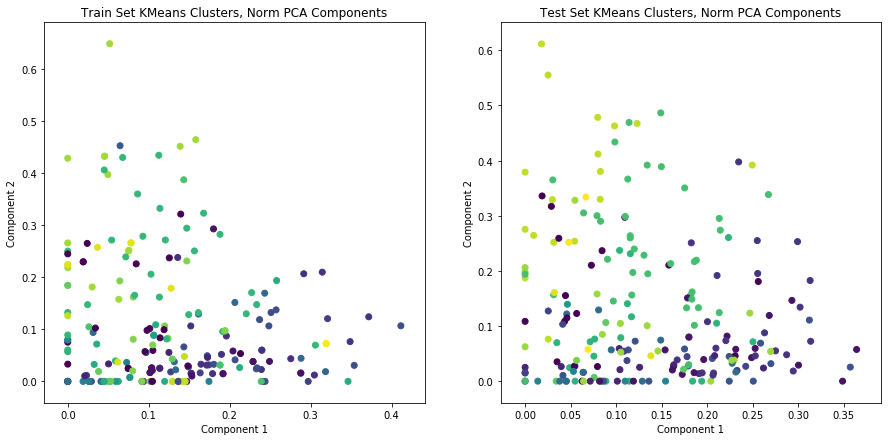

In [52]:
# Visualizing the clusters based on the first two PCA components
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
plt.scatter(train_bob_norm[:,0], train_bob_norm[:,1], c = km_train_clusts)
plt.title('Train Set KMeans Clusters, Norm PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1,2,2)
plt.scatter(test_bob_norm[:,0], test_bob_norm[:,1], c = km_test_clusts)
plt.title('Test Set KMeans Clusters, Norm PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Visually the clusters overlap significantly; the first two components, afterall, only capture around 12% of the variance of full dimensinoality of the data set. The entire PCA transformation extracts 100 PC's that contribute to the final clustering dimension of the train_set, so clustering in the higher dimensions probably creates more delineated clusters. Visuializing in 2 dimensions however is only useful insofar as it shows that the clusters aren't easily .

### --- 1b. Mean Shift

In [54]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_estimate = estimate_bandwidth(train_bob_pca, quantile = 0.5)

In [55]:
# Using elbow method to to optimize the number of clusters vs. clustering based on the number of authors in the pruned dataset

q_list = [q/10 for q in list(range(10, 11))]
silhouette_vals = []

for q in q_list:
    bandwidth_estimate = estimate_bandwidth(train_bob_pca, quantile = q)

    ms = MeanShift(bandwidth = bandwidth_estimate, bin_seeding = True)
    ms.fit(train_bob_pca)
    cluster_labels = ms.labels_
    
    sil_score = silhouette_score(train_bob_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot silhouette against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

According to the error message above, the silhouette score cannot be calculated because the meanshift clustering model can't seem to create more than one cluster. Toggling with the bandwidth estimator with quantiles ranging between 0 and 1, the number of clusters created never exceeds more than one. So mean shift will not work as a clustering method.

### --- 1c. Spectral Affinity

Text(0, 0.5, 'Silhouette Score')

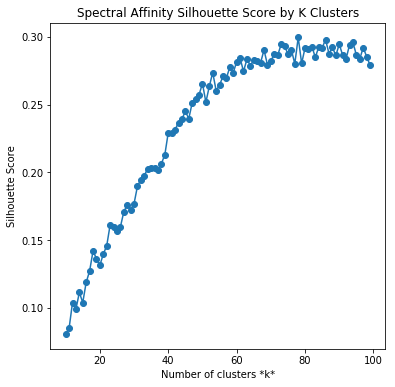

In [56]:
from sklearn.cluster import SpectralClustering

silhouette_vals = []
list_k = list(range(10, 100))

for k in list_k:
    sc = SpectralClustering(n_clusters=k, random_state = 50)
    cluster_labels = sc.fit_predict(train_bob_pca)
    sil_score = silhouette_score(train_bob_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.title('Spectral Affinity Silhouette Score by K Clusters')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

Essentially the same issue with KMeans Clustering. At this point, it seems that the best clustering is the arbitrary decision to choose the clusters based on the number of authors in the data set (22 clusters).

Or for exploratory purposed, we can set the clusters numbers at the 'elbow' of the above silhouette graph (k = 60) and see what the spectral affinity clusters returns.

In [58]:
n_clusters = bible_pruned['author'].nunique()

spec = SpectralClustering(n_clusters = n_clusters, random_state = 30)
spec_train_clusts = spec.fit_predict(train_bob_norm)

# matching clusters to text their features
spec_train_clusters_df = train_set.copy()
spec_train_clusters_df['cluster'] = spec_train_clusts

# Printing all clusters
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(spec_train_clusters_df[spec_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
1049,Revelation 3,John,NT
678,Isaiah 54,Isaiah,OT
763,Ezekiel 16,Ezekiel,OT
920,John 17,John,NT
446,Job 11,Job,OT
751,Ezekiel 4,Ezekiel,OT
678,Isaiah 54,Isaiah,OT
178,Deuteronomy 26,Moses,OT
16,Genesis 17,Moses,OT
954,Romans 2,Paul,NT


Cluster # 1


,book_chapter,author,testament
391,2 Chronicles 25,Ezra,OT
612,Ecclesiastes 8,Solomon,OT
489,Psalms 14,David,OT
394,2 Chronicles 28,Ezra,OT
708,Jeremiah 18,Jeremiah,OT
289,2 Samuel 23,Samuel,OT
305,1 Kings 15,Jeremiah,OT
764,Ezekiel 17,Ezekiel,OT
410,Ezra 8,Ezra,OT
390,2 Chronicles 24,Ezra,OT


Cluster # 2


,book_chapter,author,testament
724,Jeremiah 34,Jeremiah,OT
728,Jeremiah 38,Jeremiah,OT
429,Esther 4,Mordecai,OT
320,2 Kings 8,Jeremiah,OT
280,2 Samuel 14,Samuel,OT
323,2 Kings 11,Jeremiah,OT
406,Ezra 4,Ezra,OT
660,Isaiah 36,Isaiah,OT
330,2 Kings 18,Jeremiah,OT
742,Jeremiah 52,Jeremiah,OT


Cluster # 3


,book_chapter,author,testament
836,Matthew 1,Matthew,NT
836,Matthew 1,Matthew,NT


Cluster # 4


,book_chapter,author,testament
788,Ezekiel 41,Ezekiel,OT
787,Ezekiel 40,Ezekiel,OT
787,Ezekiel 40,Ezekiel,OT
296,1 Kings 6,Jeremiah,OT


Looking at this training set clustering, I realize that when the training set is being resampled, I need to set the replacement setting to False.

## 2. TF-IDF Feature Clustering

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting the data set into train and test sets. PP means preprocessed.
# The original train and test sets (from BOW analysis) won't be used for this feature generation method in order to model more of the data
train_set_PP, test_set_PP = train_test_split(bible_pruned, train_size = 0.75, random_state = 7)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Fitting to the train set, and transforming both sets with train fitted model.
train_set_tfidf = vectorizer.fit_transform(train_set_PP.token_text)
test_set_tfidf = vectorizer.transform(test_set_PP.token_text)

# Normalizing tfidf rows before dimension reduction
train_tfidf_norm = normalize(train_set_tfidf)
test_tfidf_norm = normalize(test_set_tfidf)


(801, 600)
(268, 600)
0.9192195079737298


Text(0, 0.5, 'Explained Variance Ratio')

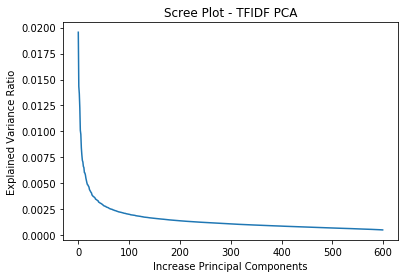

In [60]:
# PCA Dimension Reduction
pca = PCA(600)
pca.fit(train_tfidf_norm.todense())
train_tfidf_pca = pca.transform(train_tfidf_norm.todense())
test_tfidf_pca = pca.transform(test_tfidf_norm.todense())

print(train_tfidf_pca.shape)
print(test_tfidf_pca.shape)
#print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot - TFIDF PCA')
plt.xlabel('Increase Principal Components')
plt.ylabel('Explained Variance Ratio')

Although the scree plot of the principal components of the TF-IDF has a defined elbow when a large number of components are mapped out, even the intial components start with small varianace ratios. We will use 600 principal components because computation is not very expensive for clustering, and it's ideal to have above at least 90% of the variance captured by the principal components.

In [ ]:
# Testing out PCA with and without normalizing; the EVR is just about the same without normalizing.

# PCA Dimension Reduction
#pca = PCA(600)
#pca.fit(train_set_tfidf.todense())
#train_tfidf_pca = pca.transform(train_set_tfidf.todense())
#test_tfidf_pca = pca.transform(test_set_tfidf.todense())

#print(pca.explained_variance_ratio_)
#pca.explained_variance_ratio_.sum()

### --- 2a. KMeans

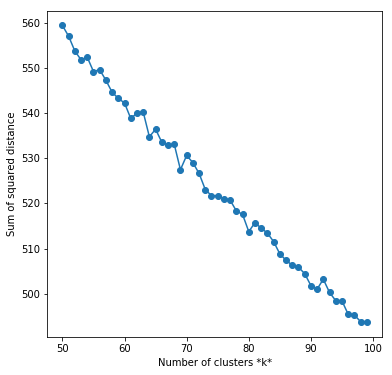

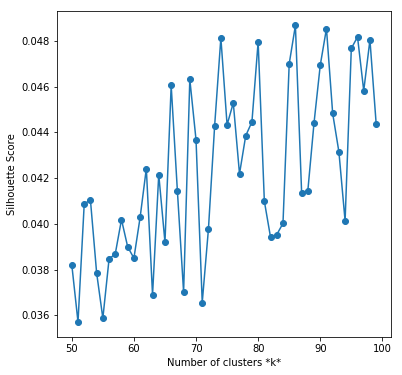

In [61]:
# Sum of squared distance and Silhouette analysis
sse = []
silhouette_vals = []
list_k = list(range(50, 100))

for k in list_k:
    # Fitting the models
    km = KMeans(n_clusters=k, random_state = 50)  
    km.fit(train_tfidf_pca)
    
    # Appending corresponding SSE to list
    sse.append(km.inertia_)
    
    # Appending corresponding Silhouette Score to list
    cluster_labels = km.fit_predict(train_tfidf_pca)
    sil_score = silhouette_score(train_tfidf_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# SSE Plot against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

# Silhouette Plot against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.show()

The silhouette and sum of squared distances graphs don't indicate that there is an optimal cluster count. Both show monotonic behavior without any indication of a global minima or maxima. Also the noise in the graphs are probably simply due to the random intial conditions of KMeans to pick arbitray intial centroid locations.

Below we will analyze the clusters based on the number of authors in the pruned dataset. (k=22) Fewer clusters makes will be easier to look into.

In [63]:
# KMeans, Looking into the clusters
n_clusters = 100 #bible_pruned['author'].nunique()

kmeans = KMeans(n_clusters = n_clusters, random_state = 30)
kmeans.fit(train_tfidf_pca)
km_train_clusts = kmeans.predict(train_tfidf_pca)
km_test_clusts = kmeans.predict(test_tfidf_pca)

# matching clusters to text their features
km_train_clusters_df = train_set_PP.copy()
km_train_clusters_df['cluster'] = km_train_clusts

km_test_clusters_df = test_set_PP.copy()
km_test_clusters_df['cluster'] = km_test_clusts

# Printing all clusters
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(km_train_clusters_df[km_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
372,2 Chronicles 6,Ezra,OT
299,1 Kings 9,Jeremiah,OT
374,2 Chronicles 8,Ezra,OT
300,1 Kings 10,Jeremiah,OT
293,1 Kings 3,Jeremiah,OT
301,1 Kings 11,Jeremiah,OT
298,1 Kings 8,Jeremiah,OT
617,Song of Solomon 1,Solomon,OT
373,2 Chronicles 7,Ezra,OT


Cluster # 1


,book_chapter,author,testament
950,Acts of the Apostles 26,Luke,NT
949,Acts of the Apostles 25,Luke,NT


Cluster # 2


,book_chapter,author,testament
565,Psalms 122,David,OT
272,2 Samuel 6,Samuel,OT
278,2 Samuel 12,Samuel,OT
371,2 Chronicles 5,Ezra,OT
353,1 Chronicles 16,Ezra,OT
352,1 Chronicles 15,Ezra,OT
7,Genesis 8,Moses,OT
240,1 Samuel 5,Samuel,OT
241,1 Samuel 6,Samuel,OT
265,1 Samuel 30,Samuel,OT


Cluster # 3


,book_chapter,author,testament
277,2 Samuel 11,Samuel,OT
283,2 Samuel 17,Samuel,OT
281,2 Samuel 15,Samuel,OT
280,2 Samuel 14,Samuel,OT
518,Psalms 45,Sons of Korah,OT
286,2 Samuel 20,Samuel,OT
291,1 Kings 1,Jeremiah,OT
292,1 Kings 2,Jeremiah,OT
198,Joshua 12,Joshua,OT
282,2 Samuel 16,Samuel,OT


Cluster # 4


,book_chapter,author,testament
660,Isaiah 36,Isaiah,OT
330,2 Kings 18,Jeremiah,OT
663,Isaiah 39,Isaiah,OT
644,Isaiah 20,Isaiah,OT
398,2 Chronicles 32,Ezra,OT
331,2 Kings 19,Jeremiah,OT
332,2 Kings 20,Jeremiah,OT
661,Isaiah 37,Isaiah,OT


In [64]:
# Printing all clusters
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(km_test_clusters_df[km_test_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
367,2 Chronicles 1,Ezra,OT
294,1 Kings 4,Jeremiah,OT
375,2 Chronicles 9,Ezra,OT


Cluster # 1


,book_chapter,author,testament


Cluster # 2


,book_chapter,author,testament
350,1 Chronicles 13,Ezra,OT
6,Genesis 7,Moses,OT


Cluster # 3


,book_chapter,author,testament
358,1 Chronicles 21,Ezra,OT
285,2 Samuel 19,Samuel,OT
284,2 Samuel 18,Samuel,OT


Cluster # 4


,book_chapter,author,testament
662,Isaiah 38,Isaiah,OT


Clusters are looking great. And the test cluster look very similar to the train clusters.

### --- 2b. Mean Shift

In [ ]:
# Mean Shift Clustering

# intializing a set of quanitile to experiment with bandwidth
q_list = [q/10 for q in list(range(1, 11))]
silhouette_vals = []

for q in q_list:
    bandwidth_estimate = estimate_bandwidth(train_tfidf_pca, quantile = q)

    ms = MeanShift(bandwidth = bandwidth_estimate, bin_seeding = True)
    ms.fit(train_tfidf_pca)
    cluster_labels = ms.labels_
    
    sil_score = silhouette_score(train_tfidf_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot silhouette against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

Mean shift does not create more than 1 cluster. Can't be used.

### --- 2c. Spectral Affinity

Text(0, 0.5, 'Silhouette Score')

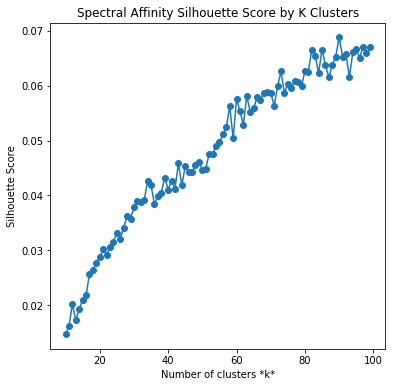

In [65]:
from sklearn.cluster import SpectralClustering

silhouette_vals = []
list_k = list(range(10, 100))

for k in list_k:
    sc = SpectralClustering(n_clusters=k, random_state = 50)
    cluster_labels = sc.fit_predict(train_tfidf_pca)
    sil_score = silhouette_score(train_tfidf_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.title('Spectral Affinity Silhouette Score by K Clusters')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

The silhouette score for spectral affinity clustering increases as the number of clusters increases.

In [66]:
# Spectral Affinity; Looking into the cluster

n_clusters = 100#bible_pruned['author'].nunique()

spec = SpectralClustering(n_clusters = n_clusters, random_state = 30)
spec_train_clusts = spec.fit_predict(train_tfidf_pca)

# matching clusters to text their features
spec_train_clusters_df = train_set_PP.copy()
spec_train_clusters_df['cluster'] = spec_train_clusts

# Printing all clusters
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(spec_train_clusters_df[spec_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
158,Deuteronomy 6,Moses,OT
159,Deuteronomy 7,Moses,OT
167,Deuteronomy 15,Moses,OT
751,Ezekiel 4,Ezekiel,OT
72,Exodus 23,Moses,OT
165,Deuteronomy 13,Moses,OT
178,Deuteronomy 26,Moses,OT
160,Deuteronomy 8,Moses,OT
156,Deuteronomy 4,Moses,OT
182,Deuteronomy 30,Moses,OT


Cluster # 1


,book_chapter,author,testament
737,Jeremiah 47,Jeremiah,OT
806,Daniel 11,Daniel,OT
830,Zechariah 9,Zechariah,OT
1064,Revelation 18,John,NT
740,Jeremiah 50,Jeremiah,OT
715,Jeremiah 25,Jeremiah,OT
658,Isaiah 34,Isaiah,OT
700,Jeremiah 10,Jeremiah,OT
645,Isaiah 21,Isaiah,OT
181,Deuteronomy 29,Moses,OT


Cluster # 2


,book_chapter,author,testament
316,2 Kings 4,Jeremiah,OT
810,Hosea 3,Hosea,OT
894,Luke 15,Luke,NT
837,Matthew 2,Matthew,NT
188,Joshua 2,Joshua,OT
71,Exodus 22,Moses,OT
101,Leviticus 12,Moses,OT
70,Exodus 21,Moses,OT
177,Deuteronomy 25,Moses,OT
37,Genesis 38,Moses,OT


Cluster # 3


,book_chapter,author,testament
318,2 Kings 6,Jeremiah,OT
319,2 Kings 7,Jeremiah,OT
323,2 Kings 11,Jeremiah,OT
286,2 Samuel 20,Samuel,OT
390,2 Chronicles 24,Ezra,OT
291,1 Kings 1,Jeremiah,OT
310,1 Kings 20,Jeremiah,OT
293,1 Kings 3,Jeremiah,OT
292,1 Kings 2,Jeremiah,OT
315,2 Kings 3,Jeremiah,OT


Cluster # 4


,book_chapter,author,testament
867,Mark 4,John Mark,NT
912,John 9,John,NT
843,Matthew 8,Matthew,NT
859,Matthew 24,Matthew,NT
840,Matthew 5,Matthew,NT
900,Luke 21,Luke,NT
854,Matthew 19,Matthew,NT
885,Luke 6,Luke,NT
872,Mark 9,John Mark,NT
851,Matthew 16,Matthew,NT


In [67]:
n_clusters = 100 #bible_pruned['author'].nunique()

spec = SpectralClustering(n_clusters = n_clusters, random_state = 30)
spec_test_clusts = spec.fit_predict(test_tfidf_pca)

# matching clusters to text their features
spec_test_clusters_df = test_set_PP.copy()
spec_test_clusters_df['cluster'] = spec_test_clusts

# Printing all clusters
for cluster in range(5): # range(n_clusters) for all clusters
    print('Cluster #', cluster)
    display(spec_test_clusters_df[spec_test_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])
    

Cluster # 0


,book_chapter,author,testament
722,Jeremiah 32,Jeremiah,OT
734,Jeremiah 44,Jeremiah,OT


Cluster # 1


,book_chapter,author,testament
996,2 Corinthians 12,Paul,NT
972,1 Corinthians 4,Paul,NT
983,1 Corinthians 15,Paul,NT


Cluster # 2


,book_chapter,author,testament
113,Leviticus 24,Moses,OT
53,Exodus 4,Moses,OT
125,Numbers 9,Moses,OT
128,Numbers 12,Moses,OT
141,Numbers 25,Moses,OT
186,Deuteronomy 34,Joshua,OT


Cluster # 3


,book_chapter,author,testament
54,Exodus 5,Moses,OT
60,Exodus 11,Moses,OT
1068,Revelation 22,John,NT
58,Exodus 9,Moses,OT
813,Hosea 6,Hosea,OT
418,Nehemiah 6,Nehemiah,OT
417,Nehemiah 5,Nehemiah,OT
57,Exodus 8,Moses,OT
63,Exodus 14,Moses,OT


Cluster # 4


,book_chapter,author,testament
686,Isaiah 62,Isaiah,OT
852,Matthew 17,Matthew,NT
874,Mark 11,John Mark,NT
897,Luke 18,Luke,NT
881,Luke 2,Luke,NT
889,Luke 10,Luke,NT
898,Luke 19,Luke,NT
856,Matthew 21,Matthew,NT


Experimenting with increasing the number of clusters for spectral affinity to k=100 above, the clusters in the train set group the same authors together very well, even across different books that the same authors wrote.

--- Clustering Conclusions ---

The overall clustering in euclidean space was bad enough that Mean Shift clustering couldn't make out more than one cluster among the entire training set.

However, looking into the clusters for both BOW and TF-IDF vectorizations demonstrated failry great clustering of authors even among the different books that each author contributed to; and the models proved to cluster the test sets very similar although with a little more noise (as expected).

Analytically, the BOW vectorization lead to smaller Sum of Squared Errors and larger Silhouette Scores than TF-IDF vectorization. These metrics both indicate that BOW produced more geometrically defined clusters.

Even in the supervised model to predict the testament to which a book chapter belonged produced a higher accuracy using BOW vectorizatiion versus TF-IDF vectorization. However, it's important to note that the SSE for the BOW features is smaller probably due to the smaller sample size; unfortunately space cannot handle more than 1 million characters at a time, so the training set had to be significantly reduced. (Also, BOW vectors take a lot of computing power to process).

Thus far BOW seems to be winning out as a clustering method. A few more experiments are graphs the test_set scores for the BOW vectors and increases clusters beyond the 22 cluster limit that I've been honoring. Although I have kept the clusters at the number of authors for each of teh clustering methods, it seems that the more clusters there are, the better they'll predict the author as was seen looking into the cluster empirically and also through the increase of the silhouette score as the number of clusters increases.

# Supervised Classification using Unsupervised Generated Features
Predicting the authors of the bible book_chapters.
---
Questions:
- Can unsupervised generated cluster assignments be used as a feature in a supervised learning classifier?
- What other unsupervised methods are there to extract features besides PCA and LSA? 

Game Plan:
Take the processed BOB (BOW) features and perform LSA on the features. Try classifying the text with and without normalizing the LSA results.

Then take the processed TF-IDF features, this time use truncated LSA and perform classification both with and with using normalized samples.

Classification methods to use include random forest, logistic regression, or other linear regression models, gradient boosting.

----

Also experiment with how well PCA creates clusters vs. LSA. Always normalize LSA components results.

Does PCA need to be normalized after?

I'm confused because PCA is normalized before transformation, while LSA uses normalization after. What's the deal? Why don't we normalize before using LSA? -- the internet seems to say that while there are definitely differences between PCA and LSA, it's up to the scientist to experiement with which methods work best.

What other unsupervised feature extraction methods can be used?

We aren't going to use the clusters as features; we'll just let those clusters be relatively purposeless. So it's okay.

Variables:
- BOW vs. TFIDF
- Either normalization before PCA, or normalization after PSA
- Supervised Learning Model

### 1. BOW Features Author Classification

In [ ]:
# Variables for recal reference:
# train_set      =>
# test_set       =>
# train_set_PP
# test_set_PP
# train_set_bob
# test_set_bob
# train_set_tfidf
# train_set_tfidf

### --- 1a. PCA Features

In [106]:
train_bob_norm = normalize(train_set_bob)
test_bob_norm = normalize(test_set_bob)

pca = PCA(100)
pca.fit(train_bob_norm)
train_bob_pca = pca.transform(train_bob_norm)
test_bob_pca = pca.transform(test_bob_norm)

X_train = train_bob_pca
Y_train = train_set['author']
X_test = test_bob_pca
Y_test = test_set['author']

In [107]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 500)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)
bowpcarfc = clf.score(X_test,Y_test)
print(bowpcarfc)
#confusion_matrix(Y_test,Y_predict)

0.5841121495327103


In [108]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 250)
clf.fit(X_train,Y_train)
bowpcagbc = clf.score(X_test,Y_test)
print(bowpcagbc)

0.3130841121495327


In [ ]:
# Support Vector Machines
from sklearn.svm import SVC

clf = SVC(degree = 3)
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

### --- 1b. LSA Features

In [109]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
train_bob_svd = svd.fit_transform(train_set_bob)
test_bob_svd = svd.transform(test_set_bob)

train_bob_lsa = normalize(train_bob_svd)
test_bob_lsa = normalize(test_bob_svd)

X_train = train_bob_lsa
Y_train = train_set['author']
X_test = test_bob_lsa
Y_test = test_set['author']

svd.explained_variance_ratio_.sum()

0.9587011293847341

In [110]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 50)
clf.fit(X_train, Y_train)
bowlsarfc = clf.score(X_test,Y_test)
print(bowlsarfc)

0.5560747663551402


In [111]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 250)
clf.fit(X_train,Y_train)
bowlsagbc = clf.score(X_test,Y_test)
print(bowlsagbc)

0.32242990654205606


In [112]:
# Support Vector Machines
from sklearn.svm import SVC

clf = SVC(degree = 3)
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.20093457943925233

### --- 1c. LDA Features 

In [113]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 100)
train_bob_lda = lda.fit_transform(train_set_bob)
test_bob_lda = lda.transform(test_set_bob)

X_train = train_bob_lda
Y_train = train_set['author']
X_test = test_bob_lda
Y_test = test_set['author']

In [114]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 100)
clf.fit(X_train, Y_train)
bowldarfc = clf.score(X_test,Y_test)
print(bowldarfc)

0.4439252336448598


In [115]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
bowldagbc = clf.score(X_test,Y_test)
print(bowldagbc)

0.5747663551401869


### --- 1d. NMF Features

In [116]:
from sklearn.decomposition import NMF

nmf = NMF(n_components = 100)
train_bob_nmf = nmf.fit_transform(train_set_bob)
test_bob_nmf = nmf.transform(test_set_bob)

X_train = train_bob_nmf
Y_train = train_set['author']
X_test = test_bob_nmf
Y_test = test_set['author']

In [117]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 500)
clf.fit(X_train, Y_train)
bownmfrfc = clf.score(X_test,Y_test)
print(bownmfrfc)

0.5794392523364486


In [118]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
bownmfgbc = clf.score(X_test,Y_test)
print(bownmfgbc)

0.40654205607476634


## 2. TF-IDF Feature Classification

### --- 2a. PCA Feature Extraction

In [119]:
train_tfidf_norm = normalize(train_set_tfidf)
test_tfidf_norm = normalize(test_set_tfidf)

pca = PCA(100)
pca.fit(train_tfidf_norm.todense())
train_tfidf_pca = pca.transform(train_tfidf_norm.todense())
test_tfidf_pca = pca.transform(test_tfidf_norm.todense())

X_train = train_tfidf_pca
Y_train = train_set_PP['author']
X_test = test_tfidf_pca
Y_test = test_set_PP['author']

In [120]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 100)
clf.fit(X_train, Y_train)
tfidfpcarfc = clf.score(X_test,Y_test)
print(tfidfpcarfc)

0.7313432835820896


In [121]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
tfidfpcagbc = clf.score(X_test,Y_test)
print(tfidfpcagbc)

0.5522388059701493


### --- 2b. LSA Feature Extraction

In [122]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
train_tfidf_svd = svd.fit_transform(train_set_tfidf)
test_tfidf_svd = svd.transform(test_set_tfidf)

train_tfidf_lsa = normalize(train_tfidf_svd)
test_tfidf_lsa = normalize(test_tfidf_svd)

X_train = train_tfidf_lsa
Y_train = train_set_PP['author']
X_test = test_tfidf_lsa
Y_test = test_set_PP['author']

svd.explained_variance_ratio_.sum()

0.38792471878982754

In [123]:
#RandomForestClassifier
clf = RandomForestClassifier(max_depth = 20, n_estimators = 500)
clf.fit(X_train, Y_train)
tfidflsarfc = clf.score(X_test,Y_test)
print(tfidflsarfc)

0.7574626865671642


In [124]:
#GradientBoostingClassifier
clf = GradientBoostingClassifier(max_depth=20, n_estimators = 500)
clf.fit(X_train,Y_train)
tfidflsagbc = clf.score(X_test,Y_test)
print(tfidflsagbc)

0.6119402985074627


### --- 2c. LDA Feature Extraction

In [125]:
lda = LatentDirichletAllocation(n_components = 100)
train_tfidf_lda = lda.fit_transform(train_set_tfidf)
test_tfidf_lda = lda.transform(test_set_tfidf)

X_train = train_tfidf_lda
Y_train = train_set_PP['author']
X_test = test_tfidf_lda
Y_test = test_set_PP['author']

In [126]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 50)
clf.fit(X_train, Y_train)
tfidfldarfc = clf.score(X_test,Y_test)
print(tfidfldarfc)

0.48880597014925375


In [127]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
tfidfldagbc = clf.score(X_test,Y_test)
print(tfidfldagbc)

0.4253731343283582


### --- 2d. NMF Feature Extraction

In [128]:
nmf = NMF(n_components = 100)
train_tfidf_nmf = nmf.fit_transform(train_set_tfidf)
test_tfidf_nmf = nmf.transform(test_set_tfidf)

X_train = train_tfidf_nmf
Y_train = train_set_PP['author']
X_test = test_tfidf_nmf
Y_test = test_set_PP['author']

In [129]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 500)
clf.fit(X_train, Y_train)
tfidfnmfrfc = clf.score(X_test,Y_test)
print(tfidfnmfrfc)

0.7126865671641791


In [130]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 500)
clf.fit(X_train,Y_train)
tfidfnmfgbc = clf.score(X_test,Y_test)
print(tfidfnmfgbc)

0.7052238805970149


--- Results ---

In [131]:
index = ['PCA','LSA','LDA','NMF']
columns = ['BOW RCF','TFIDF RCF','BOW GBC','TFIDF GBC']
results = pd.DataFrame(index = index, columns = columns)

results['BOW RCF'] = [bowpcarfc, bowlsarfc, bowldarfc, bownmfrfc]
results['TFIDF RCF'] = [tfidfpcarfc, tfidflsarfc, tfidfldarfc, tfidfnmfrfc]
results['BOW GBC'] = [bowpcagbc, bowlsagbc, bowldagbc, bownmfgbc]
results['TFIDF GBC'] = [tfidfpcagbc, tfidflsagbc, tfidfldagbc, tfidfnmfgbc]

display(results)

,BOW RCF,TFIDF RCF,BOW GBC,TFIDF GBC
PCA,0.584112,0.731343,0.313084,0.552239
LSA,0.556075,0.757463,0.322430,0.611940
LDA,0.443925,0.488806,0.574766,0.425373
NMF,0.579439,0.712687,0.406542,0.705224


--- Conclusions: Predicting Authors ---

The above accuracy scores were achieved using a pipelines of the listed word vectorization methods (BOW vs. TFIDF), unsupervised decomposition methods (PCA, LSA, LDA, or NMF), and ensemble classifiers. Each pipeline permutation was trained and tested on one of two datasets depending the model used BOW or TFIDF. Models using BOW features were required to have a smaller dataset (20% of the all the data used for training) verses the models with TF-IDF vectorization (75% of all data used for training). This is due to the fact that BOW counts requiring SpaCy could not process more than 1 million characters at a time. This smaller training set in BOW, therefore affected the accuracy score affected above.

Overall, TF-IDF models returned greater classifier accuracies than BOW models. The model that performed the strongest was the TF-IDF matrix decomposed with LSA and trained on a Random Forest Classifier, ultimately turning out an accuracy of 76.1% to classify across 22 different authors for the Bible.

Another note is that NMF decomposition resulted in the greatest difference in accuracy when switiching between BOW and TFIDF models.

--- Unsupervised Clusters ---

Returning back to the unsupervised clusters above, their empirical performance was great. Although the silhouette coefficient didn't seem to converge on a given set of correct clusters, it was clear that increase the clusters did at least make the clusters more distinct as seen by the increasing silhouette score. (Given the time, I would also calculate and graph the RAND Scores for increasing)

And looking into the clusters (trained clusters and tested clusters) it was clear that the clusters group the same author or like authors together for both BOW and TFIDF, even in the test clusters. (Note: Test cluster documents were vectorized using the features of the training sets on which clustering was then performed).

--- Clustering vs. Modeling ---

When running supervised predictive models, it's easy to get away with not really seeing the qualitaties of features that the models are extracting, especially with text data where packages like SpaCy and sklearn streamline the the feature generation of the model. Being able to create the unsupervised clusters gave me the chance to see just how well the models are able to tell and get a better sense of what qualities of the text that the models are finding and grouping together.

Looking into the clusters, for example, it was interesting to see one anomoly author (Zechariah for example) among a cluster filled with primarily another authoer (e.g. all John from the Book of Revelation). Turning to the corresponding chapter in Zechariah, the words 'horse' were used just as in some of the books of Revelation. 

Seeing the clusters gives insight on how the models is making clusters, but also unveiling simliarities in parts of the Bible that a reader might not have caught before. Clsutering thus is better when you're looking for patterns that you might not have otherwise scene.

Supervised modeling then is most useful then for finding the most salient features of a dataset then predict the class or outcome of new/unseen data.